In [1]:
from common import plot_standings_v2, NWSL
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
week = 3
year = 2023

In [3]:
df = pd.read_csv("data/" + str(year) + "/1.csv", index_col=0)[["rank"]].rename(
    columns={"rank": "1"}
)
for i in range(2, week + 1):
    df_new = pd.read_csv("data/" + str(year) + "/" + str(i) + ".csv", index_col=0)[
        ["rank"]
    ].rename(columns={"rank": str(i)})
    df = df.join(df_new)
df

,1,2,3
team,,,
POR,1,1,1
SD,2,2,3
NJNY,3,6,5
NC,4,8,10
WAS,5,3,2
LOU,6,9,9
HOU,7,4,6
CHI,8,10,8
LA,9,7,7


In [4]:
# Create fake data for the standings table
df_table = pd.read_csv("data/" + str(year) + "/" + str(week) +".csv", index_col=0)
df_table

,rank,PTS,MP,W,L,D,GF,GA,GD
team,,,,,,,,,
POR,1,7,3,2,0,1,9,2,7
WAS,2,7,3,2,0,1,5,3,2
SD,3,6,3,2,1,0,6,4,2
RGN,4,6,3,2,1,0,3,1,2
NJNY,5,6,3,2,1,0,4,3,1
HOU,6,5,3,1,0,2,3,2,1
LA,7,4,3,1,1,1,5,5,0
CHI,8,3,3,1,2,0,7,7,0
LOU,9,3,3,0,0,3,4,4,0


/home/agale/soccer-analytics/src/common/plot_standings.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 1401.6x972 with 0 Axes>

<Figure size 1946.67x1350 with 0 Axes>

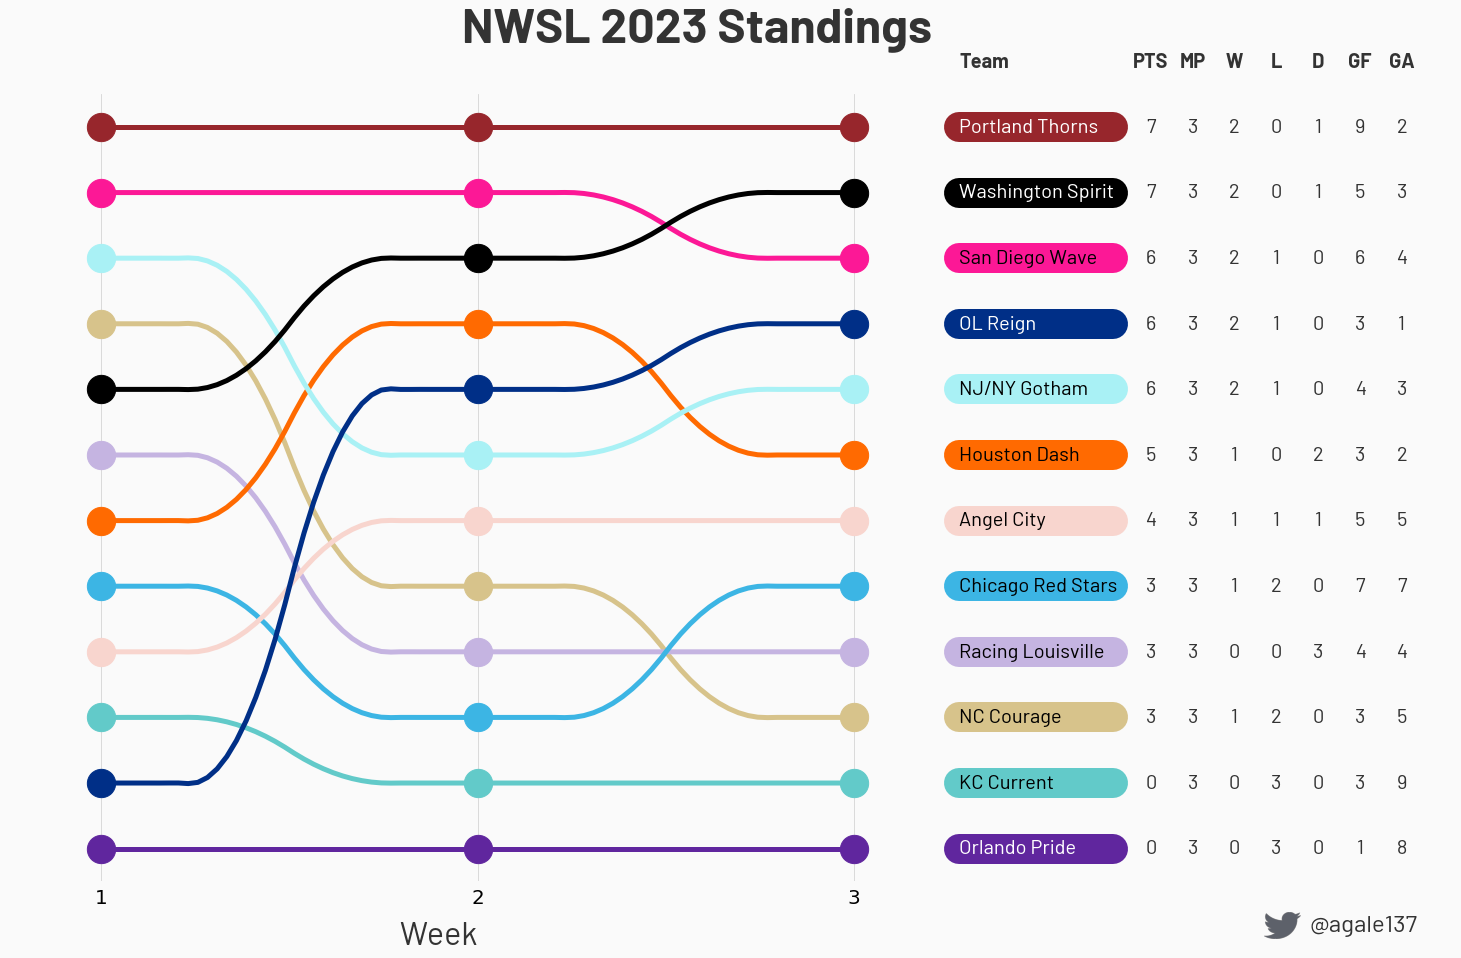

In [6]:
plot_standings_v2(
    df,
    df_table[["PTS", "MP", "W", "L", "D", "GF", "GA"]],
    folder="images/" + str(year),
    names=NWSL.NAMES,
    colors=NWSL.COLORS,
    text_colors=NWSL.TEXT_COLORS,
    title="NWSL " + str(year) + " Standings",
    label_width=0.44,
    twitter_x=0.9,
    cubic_p=0.25,
)